# Install required libraries

In [ ]:
!pip install -qq transformers
!pip install torch==1.7.1
!pip install emoji

     |████████████████████████████████| 3.1 MB 8.0 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
     |████████████████████████████████| 170 kB 12.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=16

# IMPORTS

In [ ]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, BertModel, BertTokenizer
import torch
import os
import re
import emoji
import gensim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
from shutil import copyfile

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input, GRU
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.models import Model

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn import model_selection, naive_bayes, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from google.colab import drive

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# DATASET

In [ ]:
# HATEEVAL
def load_dataset():
  df_train = pd.read_csv("/content/gdrive/MyDrive/HateEvalDataset2019/hateval2019_en_train.csv")
  df_dev = pd.read_csv("/content/gdrive/MyDrive/HateEvalDataset2019/hateval2019_en_dev.csv")
  df_test = pd.read_csv("/content/gdrive/MyDrive/HateEvalDataset2019/hateval2019_en_test.csv")

  #drop columns
  df_train.drop(df_train.columns.difference(['text','HS']), 1, inplace=True)
  df_dev.drop(df_dev.columns.difference(['text','HS']), 1, inplace=True)
  df_test.drop(df_test.columns.difference(['text','HS']), 1, inplace=True)

  # change column names
  df_train = df_train.rename(columns={'HS': 'label'})
  df_dev = df_dev.rename(columns={'HS': 'label'})
  df_test = df_test.rename(columns={'HS': 'label'})

  return df_train, df_dev, df_test

# Data Preprocessing

In [ ]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags 
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [ ]:
def remove_mentions(text):
  return re.sub("@[A-Za-z0-9_]+","@USER", text)

In [ ]:
def remove_urls(text):
  return re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "URL", text)

In [ ]:
def remove_specialChars(text):
  return re.sub("[^a-zA-Z0-9]"," ", text)

In [ ]:
def emoji_to_text(text):
  return emoji.demojize(text)

*   Removing special symbols and emoticons.
*   Transform all in lower case.
*   Remove mentions and urls.
*   Removing extra whitespaces.







In [ ]:
def preprocess_data(df_train, df_dev, df_test):
  df_train['text'] = (df_train['text'].apply(lambda x: emoji_to_text(x))
                                      .apply(lambda x: remove_mentions(x))
                                      .apply(lambda x: remove_urls(x))
                                      .apply(lambda x: remove_specialChars(x))
                                      .apply(lambda x : ' '.join(x.split()))
                                      .apply(lambda x : x.lower()))

  df_dev['text'] = (df_dev['text'].apply(lambda x: emoji_to_text(x))
                                      .apply(lambda x: remove_mentions(x))
                                      .apply(lambda x: remove_urls(x))
                                      .apply(lambda x: remove_specialChars(x))
                                      .apply(lambda x : ' '.join(x.split()))
                                      .apply(lambda x : x.lower()))

  df_test['text'] = (df_test['text'].apply(lambda x: emoji_to_text(x))
                                      .apply(lambda x: remove_mentions(x))
                                      .apply(lambda x: remove_urls(x))
                                      .apply(lambda x: remove_specialChars(x))
                                      .apply(lambda x : ' '.join(x.split()))
                                      .apply(lambda x : x.lower()))
  return df_train, df_dev, df_test

# Load Data and Preprocess it

Loading the data

In [ ]:
df_train, df_dev, df_test = load_dataset()
df_train.head()

,text,label
0,"Hurray, saving us $$$ in so many ways @potus @...",1
1,Why would young fighting age men be the vast m...,1
2,@KamalaHarris Illegals Dump their Kids at the ...,1
3,NY Times: 'Nearly All White' States Pose 'an A...,0
4,Orban in Brussels: European leaders are ignori...,0


Preprocessing

In [ ]:
df_train, df_dev, df_test = preprocess_data(df_train, df_dev, df_test)
df_train.head()

,text,label
0,hurray saving us in so many ways user user loc...,1
1,why would young fighting age men be the vast m...,1
2,user illegals dump their kids at the border li...,1
3,ny times nearly all white states pose an array...,0
4,orban in brussels european leaders are ignorin...,0


# Data Exploration

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Train data information with stopwords

In [ ]:
counts = []
mx = 0
mn = 100
unique_words = set()
stop_words = set(stopwords.words('english'))
for sen in df_train['text'] :
  words_in_sen = word_tokenize(sen)
  unique_words.update(words_in_sen)
  counts.append(len(words_in_sen))
  mx = max(mx, len(words_in_sen))
  mn = min(mn, len(words_in_sen))
print("Length of sentences with stopwords")
print("Minimum - ", mn)
print("Maximum - ", mx)
print("Number of unique words with stopwords - ", len(unique_words))

Length of sentences with stopwords
Minimum -  1
Maximum -  78
Number of unique words with stopwords -  16705


Train data information without stopwords

In [ ]:
counts = []
mx = 0
mn = 100
unique_words = set()
stop_words = set(stopwords.words('english'))
for sen in df_train['text'] :
  words_in_sen = word_tokenize(sen)
  count = 0
  for w in words_in_sen :
    if w not in stop_words:
      count += 1
      unique_words.add(w)
  counts.append(count)
  mx = max(mx, count)
  mn = min(mn, count)
print("Length of sentences without stopwords")
print("Minimum - ", mn)
print("Maximum - ", mx)
print("Number of unique words without stopwords - ", len(unique_words))

Length of sentences without stopwords
Minimum -  1
Maximum -  71
Number of unique words without stopwords -  16555


Top 80 Words

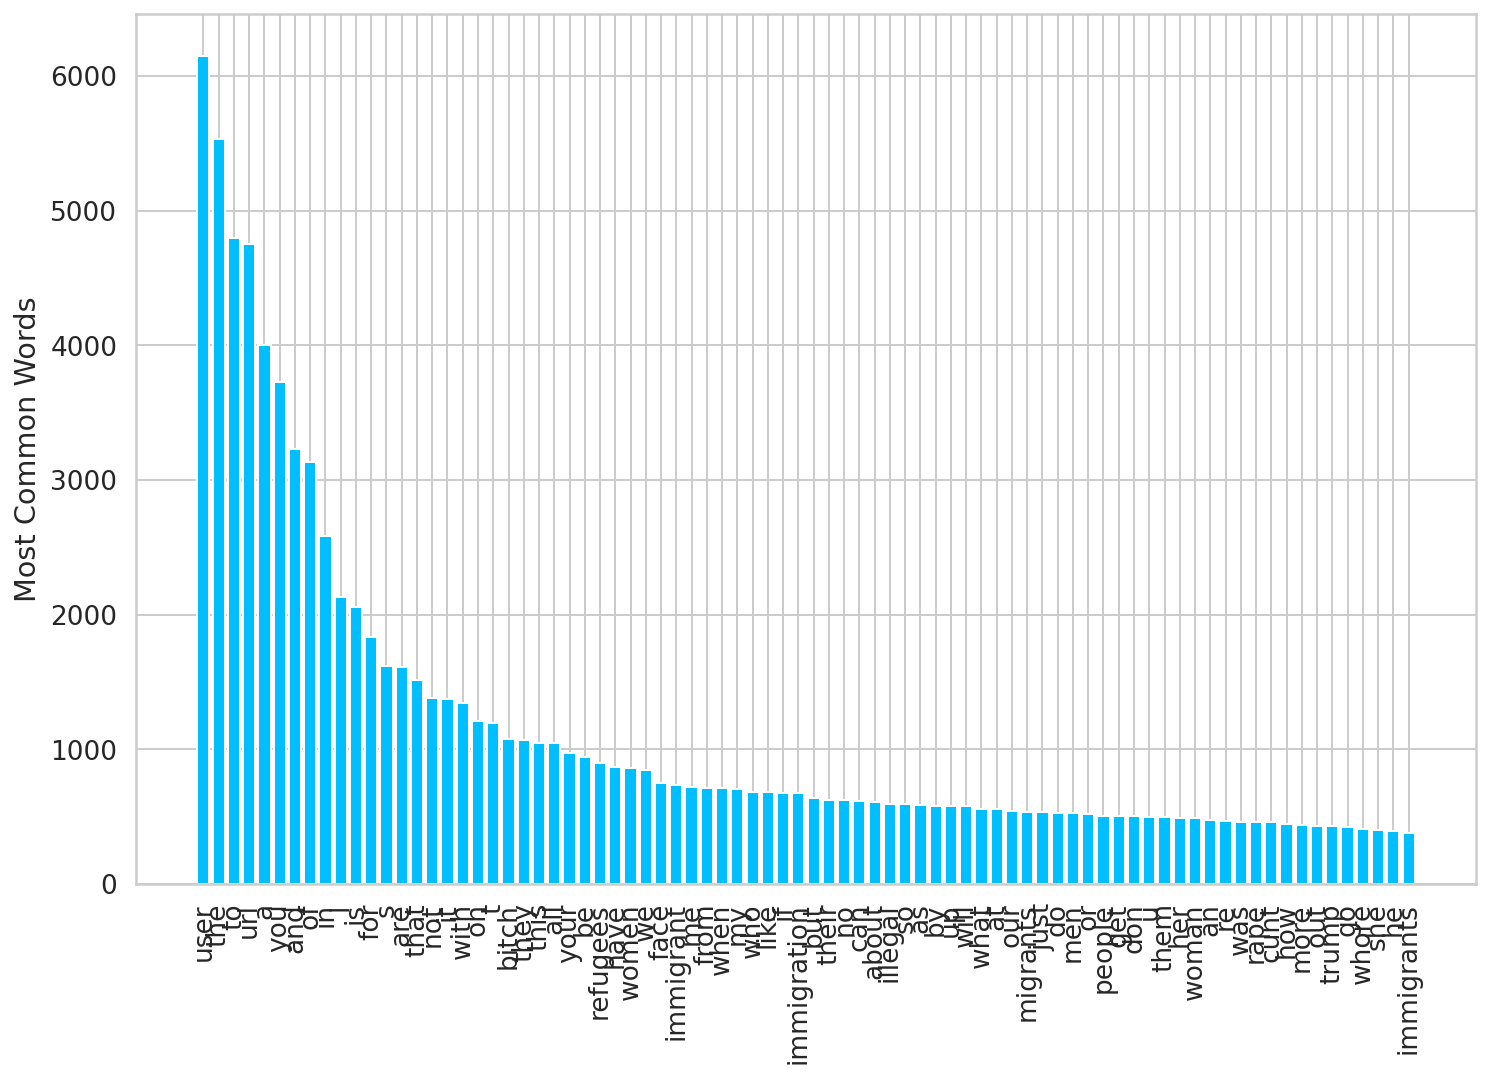

In [ ]:
from collections import Counter
s = Counter(" ".join(df_train['text']).split()).most_common(80)

word = list(zip(*s))[0]
score = list(zip(*s))[1]
x_pos = np.arange(len(word)) 

# plt.plot(x_pos, color='red')    
plt.bar(x_pos, score,align='center')
plt.xticks(rotation=90)
plt.xticks(x_pos, word) 
plt.ylabel('Most Common Words')
plt.show()

Analysis of some pejorative words in training and testing data.

In [ ]:
def pejorative_words(data):
  countBitch = 0
  countWall = 0
  for sen in data :
    words_in_sen = word_tokenize(sen)
    for w in words_in_sen :
      if w.lower() == "bitch":
        countBitch += 1
      if w.lower() == "buildthatwall" or w.lower() == "buildthewall" :
        countWall += 1
  return round((countBitch/len(data))*100, 2), round((countWall/len(data))*100, 2)

x, y = pejorative_words(df_train['text'])
print('Count of word "bitch" in train data -', x, "%")
print('Count of word "#BuildTheWall" or "#BuildThatWall" in train data -', y, "%\n")

x, y = pejorative_words(df_test['text'])
print('Count of word "bitch" in test data -', x, "%")
print('Count of word "#BuildTheWall" or "#BuildThatWall" in test data -', y, "%")

Count of word "bitch" in train data - 11.94 %
Count of word "#BuildTheWall" or "#BuildThatWall" in train data - 6.53 %

Count of word "bitch" in test data - 49.57 %
Count of word "#BuildTheWall" or "#BuildThatWall" in test data - 23.43 %


Split of hateful and non-hateful tweets in the dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Hate Speech'), Text(0, 0, 'Non Hate Speech')]

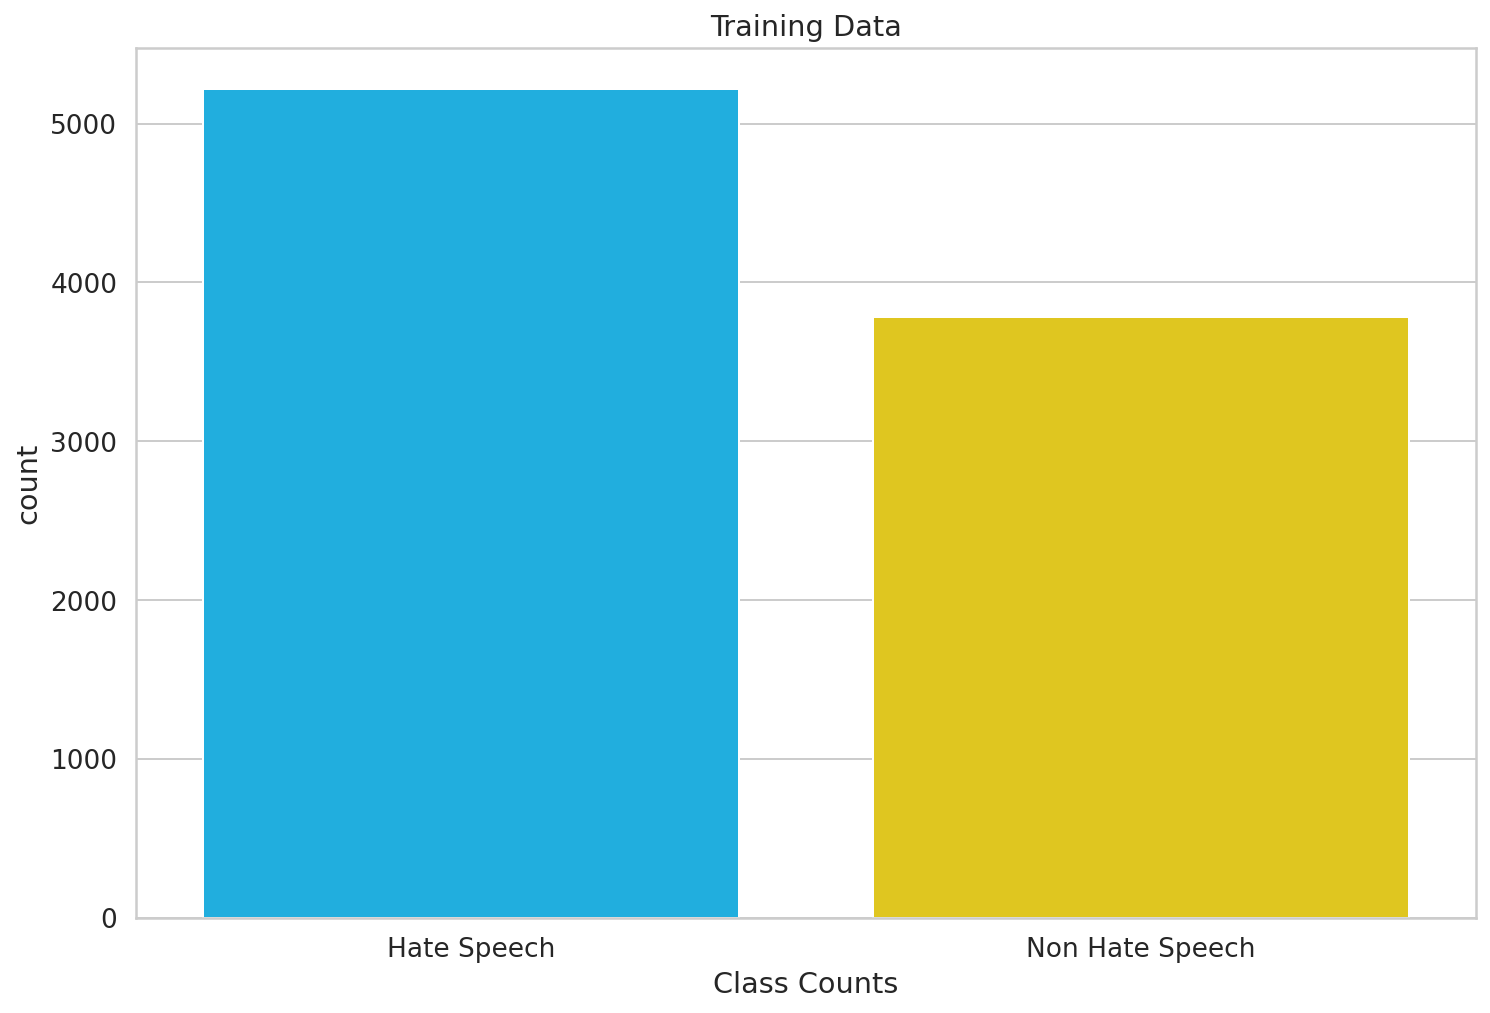

In [ ]:
class_names = ['Hate Speech', 'Non Hate Speech']
ax = sns.countplot(df_train['label'])
plt.title('Training Data')
plt.xlabel('Class Counts')
ax.set_xticklabels(class_names)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Hate Speech'), Text(0, 0, 'Non Hate Speech')]

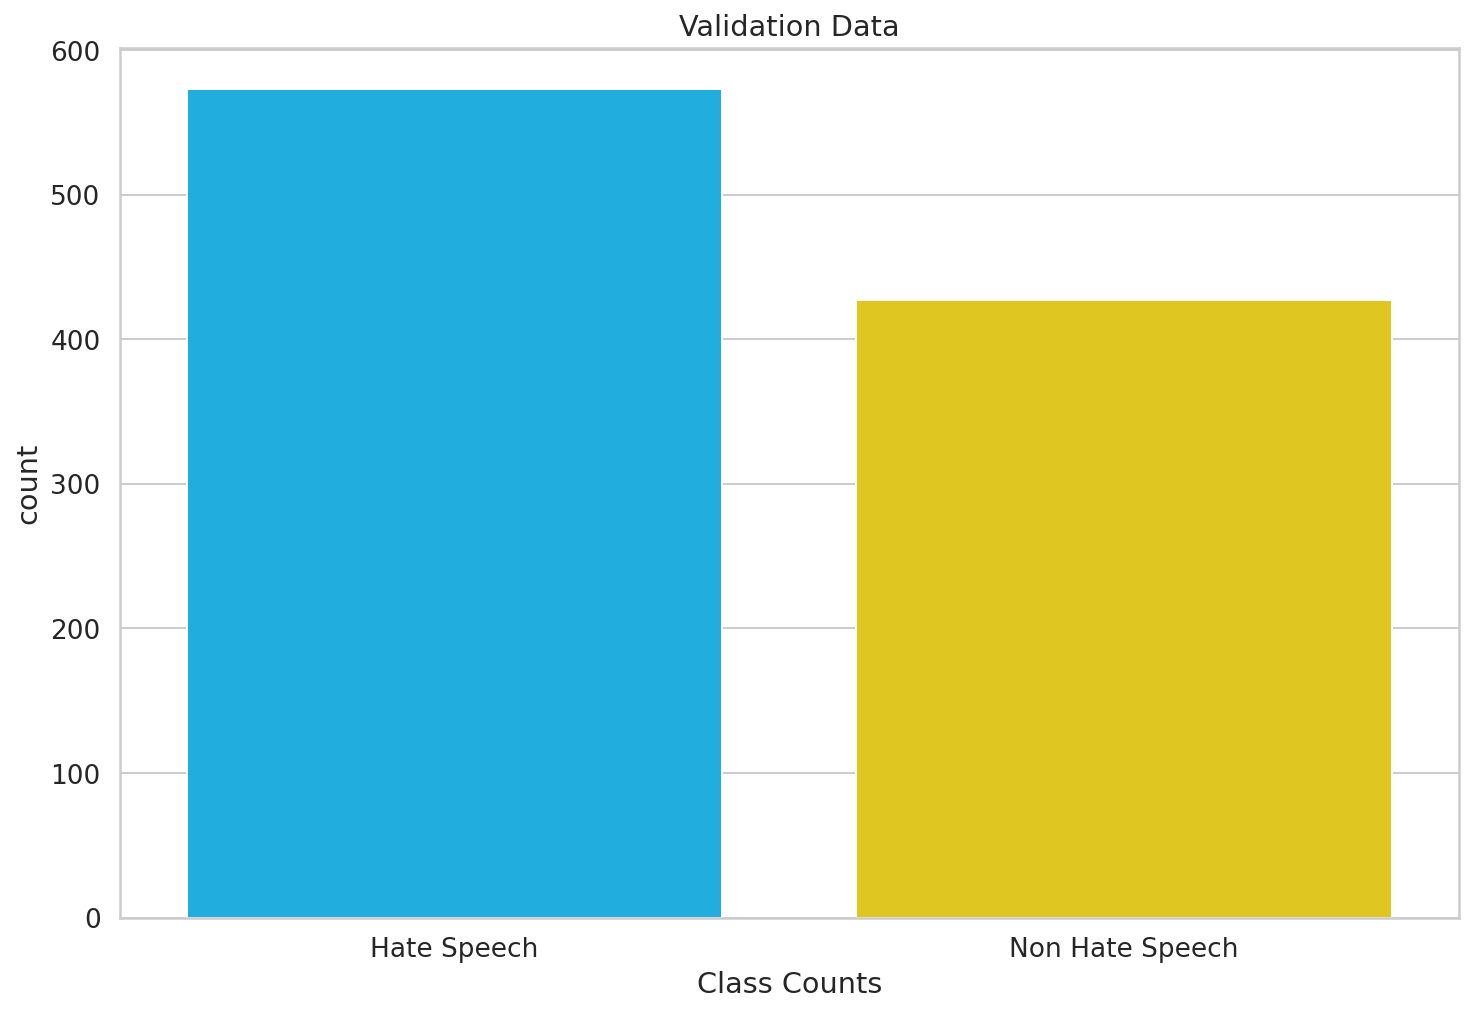

In [ ]:
class_names = ['Hate Speech', 'Non Hate Speech']
ax = sns.countplot(df_dev['label'])
plt.title('Validation Data')
plt.xlabel('Class Counts')
ax.set_xticklabels(class_names)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Hate Speech'), Text(0, 0, 'Non Hate Speech')]

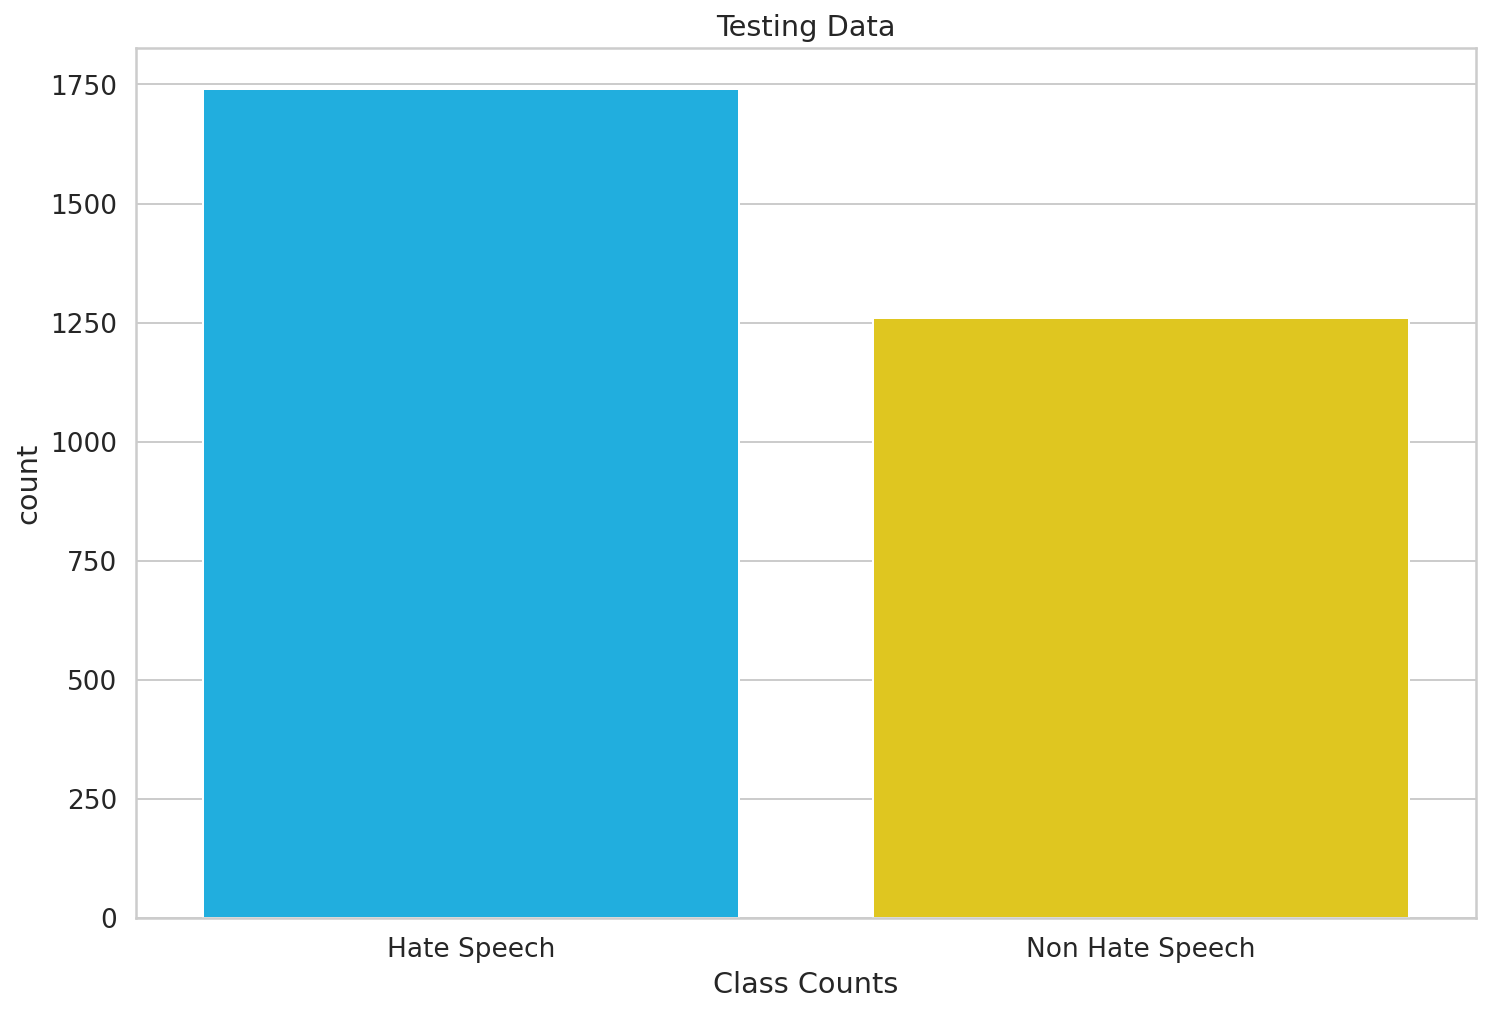

In [ ]:
class_names = ['Hate Speech', 'Non Hate Speech']
ax = sns.countplot(df_test['label'])
plt.title('Testing Data')
plt.xlabel('Class Counts')
ax.set_xticklabels(class_names)

# Machine Learning Models

In [ ]:
def train(model):
  skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

  vect = CountVectorizer()
    
  vect.fit(df_train.text)
  
  x = vect.transform(df_train.text)
  dev_X = vect.transform(df_dev.text)
  test_X = vect.transform(df_test.text)

  kFoldVal = [{'f1':[]}, {'acc':[]}]
  devData = [{'f1':[]}, {'acc':[]}]
  testData = [{'f1':[]}, {'acc':[]}, {'precision':[]}, {'recall':[]}]
  
  for train_index, test_index in skf.split(x, y):
    train_x, test_x = x[train_index], x[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    model.fit(train_x, train_y)

    kFoldVal[0]['f1'].append(f1_score(test_y, model.predict(test_x)))
    devData[0]['f1'].append(f1_score(dev_Y, model.predict(dev_X)))
    testData[0]['f1'].append(f1_score(test_Y, model.predict(test_X)))

    kFoldVal[1]['acc'].append(accuracy_score(test_y, model.predict(test_x)))
    devData[1]['acc'].append(accuracy_score(dev_Y, model.predict(dev_X)))
    testData[1]['acc'].append(accuracy_score(test_Y, model.predict(test_X)))

    testData[2]['precision'].append(precision_score(test_Y, model.predict(test_X)))
    testData[3]['recall'].append(recall_score(test_Y, model.predict(test_X)))
  
  print(classification_report(test_Y, model.predict(test_X)))


  def plot():
    # F1 score
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.plot(kFoldVal[0]['f1'], "--o")
    plt.plot(devData[0]['f1'], "--o")
    plt.plot(testData[0]['f1'], "--o")
    plt.title("F1 score plot")
    plt.ylabel("F1 Score")
    plt.xlabel("Number of Splits")
    plt.legend(['K Fold Validation', 'Dev data', 'Test data'], loc='best')
    plt.show()
    print("K Fold Validation F1 Score mean value : ", np.mean(kFoldVal[0]['f1']), "\n")
    print("Dev Data F1 Score mean value : ",np.mean(devData[0]['f1']), "\n")
    print("Test Data F1 Score mean value : ",np.mean(testData[0]['f1']), "\n")

    # Accuracy
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.plot(kFoldVal[1]['acc'], "--o")
    plt.plot(devData[1]['acc'], "--o")
    plt.plot(testData[1]['acc'], "--o")
    plt.title("Accuracy plot")
    plt.ylabel("Accuarcy")
    plt.xlabel("Number of Splits")
    plt.legend(['K Fold Validation', 'Dev data', 'Test data'], loc='best')
    plt.show()
    print("K Fold Validation Accuracy mean value : ", np.mean(kFoldVal[1]['acc']), "\n")
    print("Dev Data Accuracy mean value : ",np.mean(devData[1]['acc']), "\n")
    print("Test Data Accuracy mean value : ",np.mean(testData[1]['acc']), "\n")

    # Precision and Recall
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.plot(testData[2]['precision'], "--o")
    plt.plot(testData[3]['recall'], "--o")
    plt.title("Test Precision and recall plot")
    plt.xlabel("Number of Splits")
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()
    print("Test Data Precision Score mean value : ",np.mean(testData[2]['precision']), "\n")
    print("Test Data Recall Score mean value : ",np.mean(testData[3]['recall']), "\n")

  plot()

In [ ]:
x = df_train.text
y = df_train['label']

dev_X = df_dev.text
dev_Y = df_dev['label']

test_X = df_test.text
test_Y = df_test['label']

## WITH COUNT VECTORIZER

### SVM

========SVM============
              precision    recall  f1-score   support

           0       0.73      0.23      0.35      1740
           1       0.45      0.88      0.60      1260

    accuracy                           0.51      3000
   macro avg       0.59      0.56      0.48      3000
weighted avg       0.61      0.51      0.46      3000



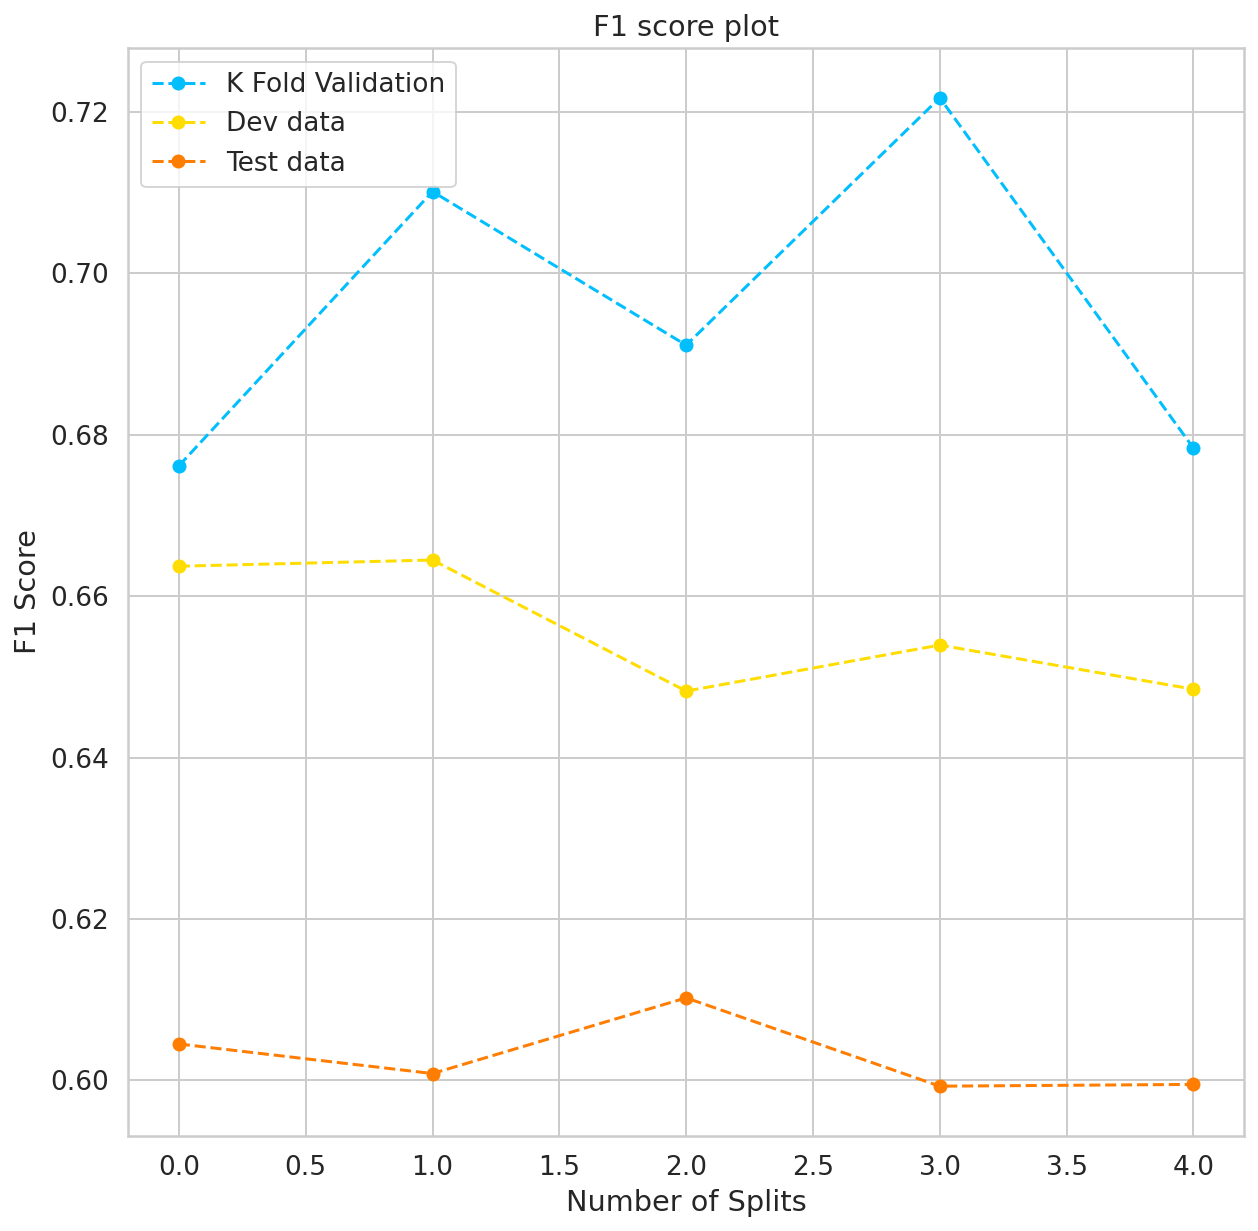

K Fold Validation F1 Score mean value :  0.6954730143999852 

Dev Data F1 Score mean value :  0.6557580775818976 

Test Data F1 Score mean value :  0.6028848835614312 



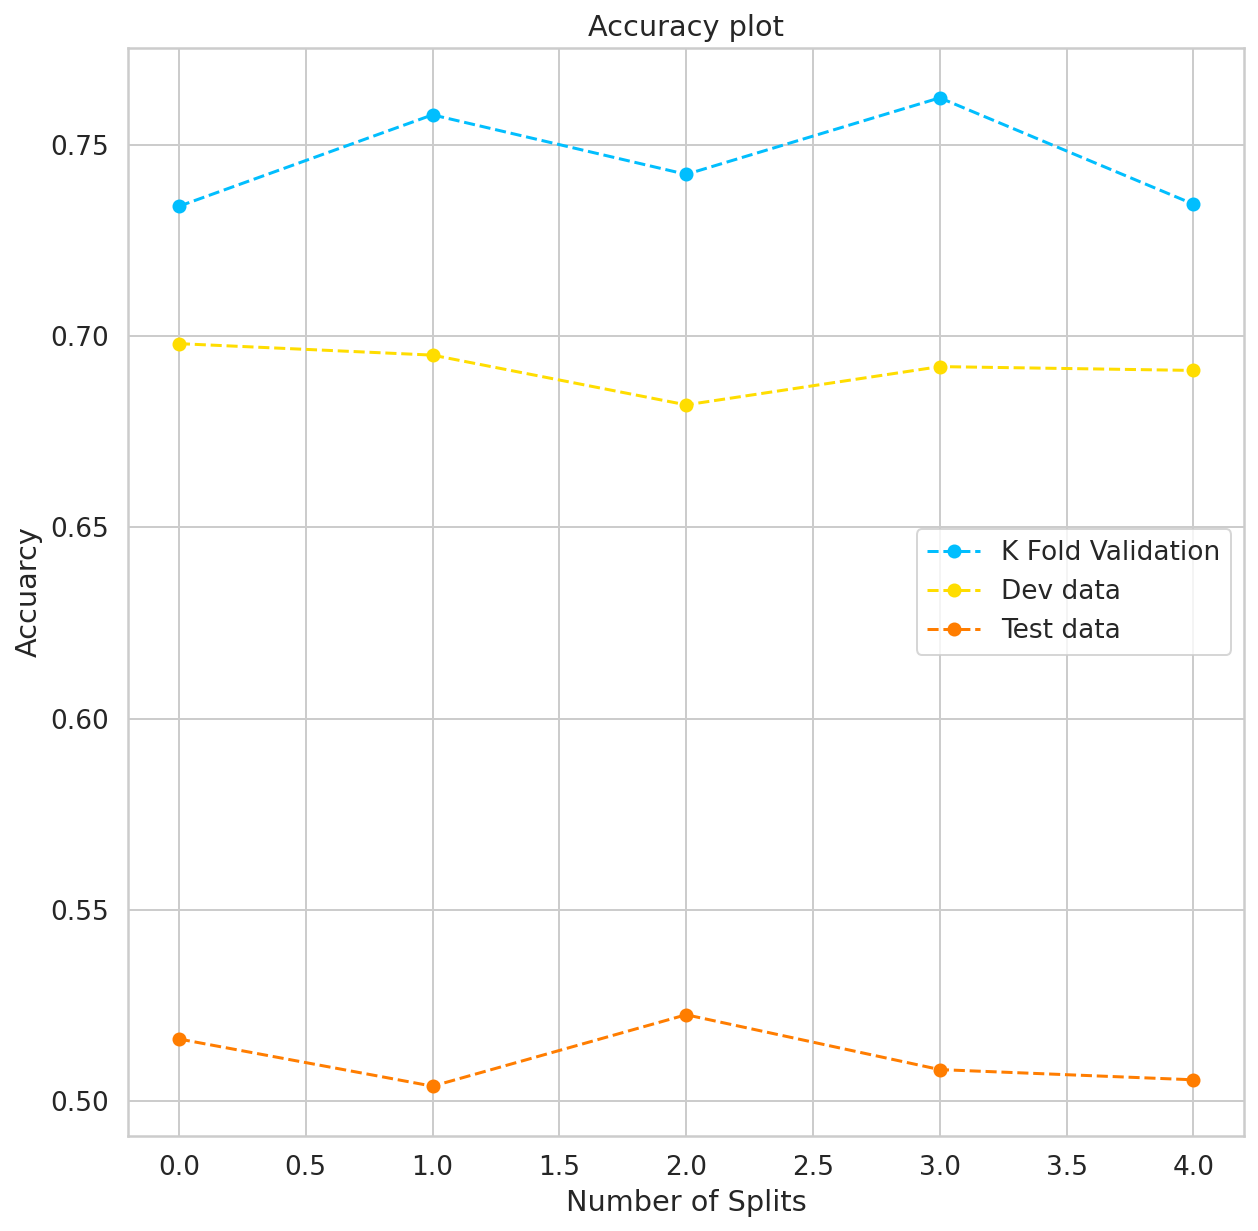

K Fold Validation Accuracy mean value :  0.7461111111111112 

Dev Data Accuracy mean value :  0.6915999999999999 

Test Data Accuracy mean value :  0.5113999999999999 



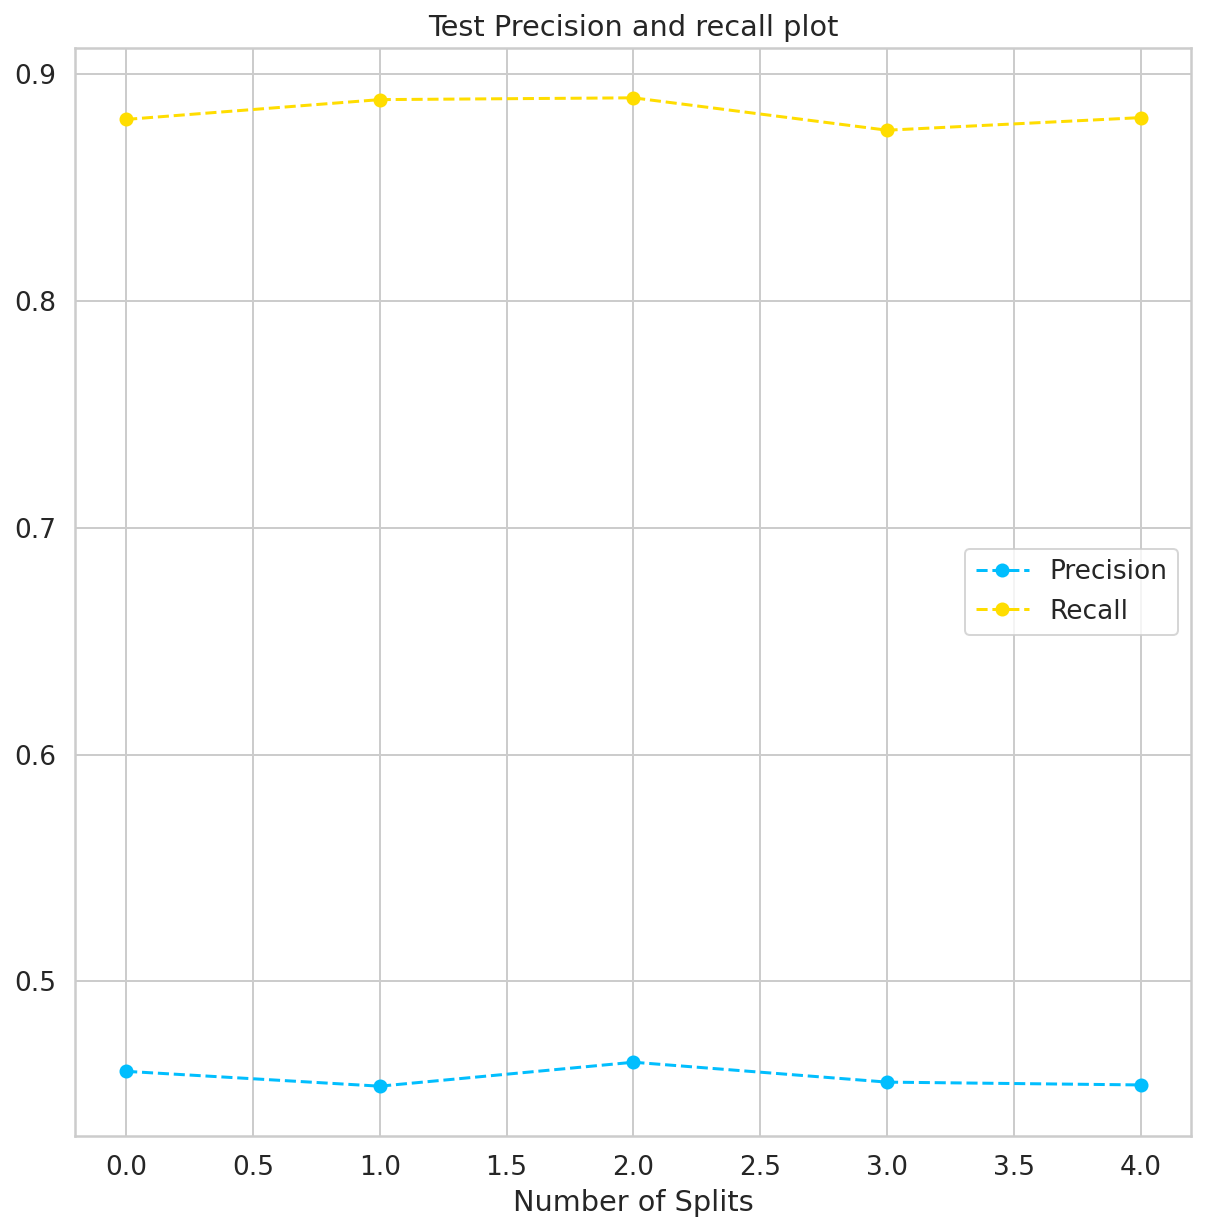

Test Data Precision Score mean value :  0.4576992967611078 

Test Data Recall Score mean value :  0.8830158730158729 



In [ ]:
print("========SVM============")
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
train(SVM)

### NAIVE BAYES

========Naive Bayes==========
              precision    recall  f1-score   support

           0       0.80      0.13      0.23      1740
           1       0.44      0.95      0.61      1260

    accuracy                           0.48      3000
   macro avg       0.62      0.54      0.42      3000
weighted avg       0.65      0.48      0.39      3000



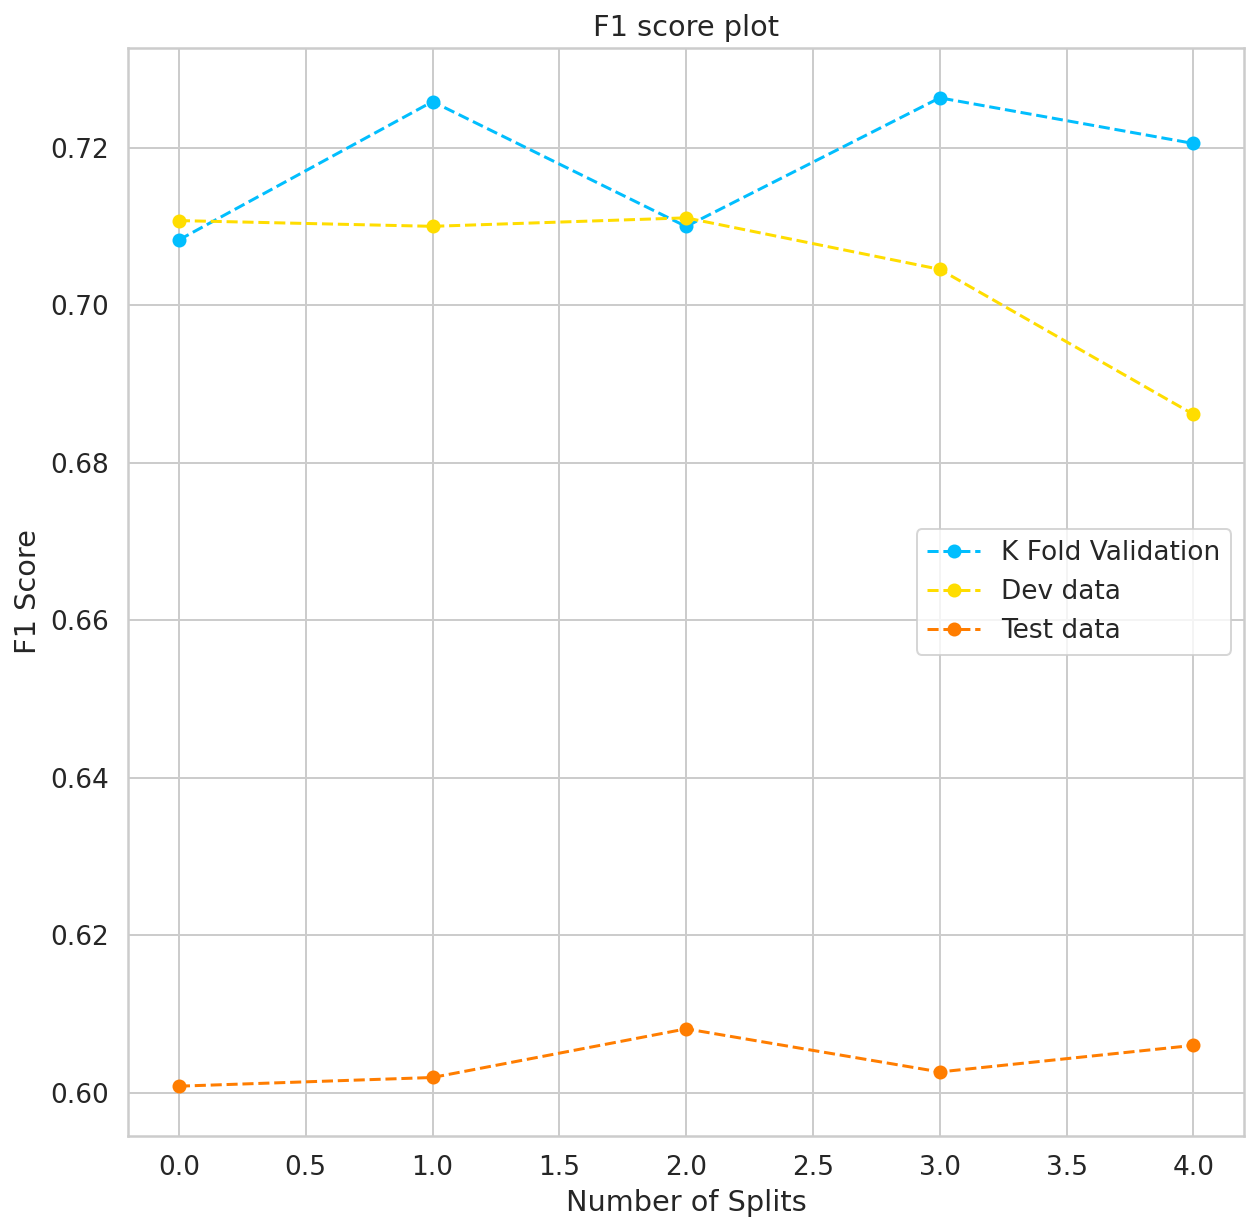

K Fold Validation F1 Score mean value :  0.7182177636213501 

Dev Data F1 Score mean value :  0.7045283080046556 

Test Data F1 Score mean value :  0.6039374956240875 



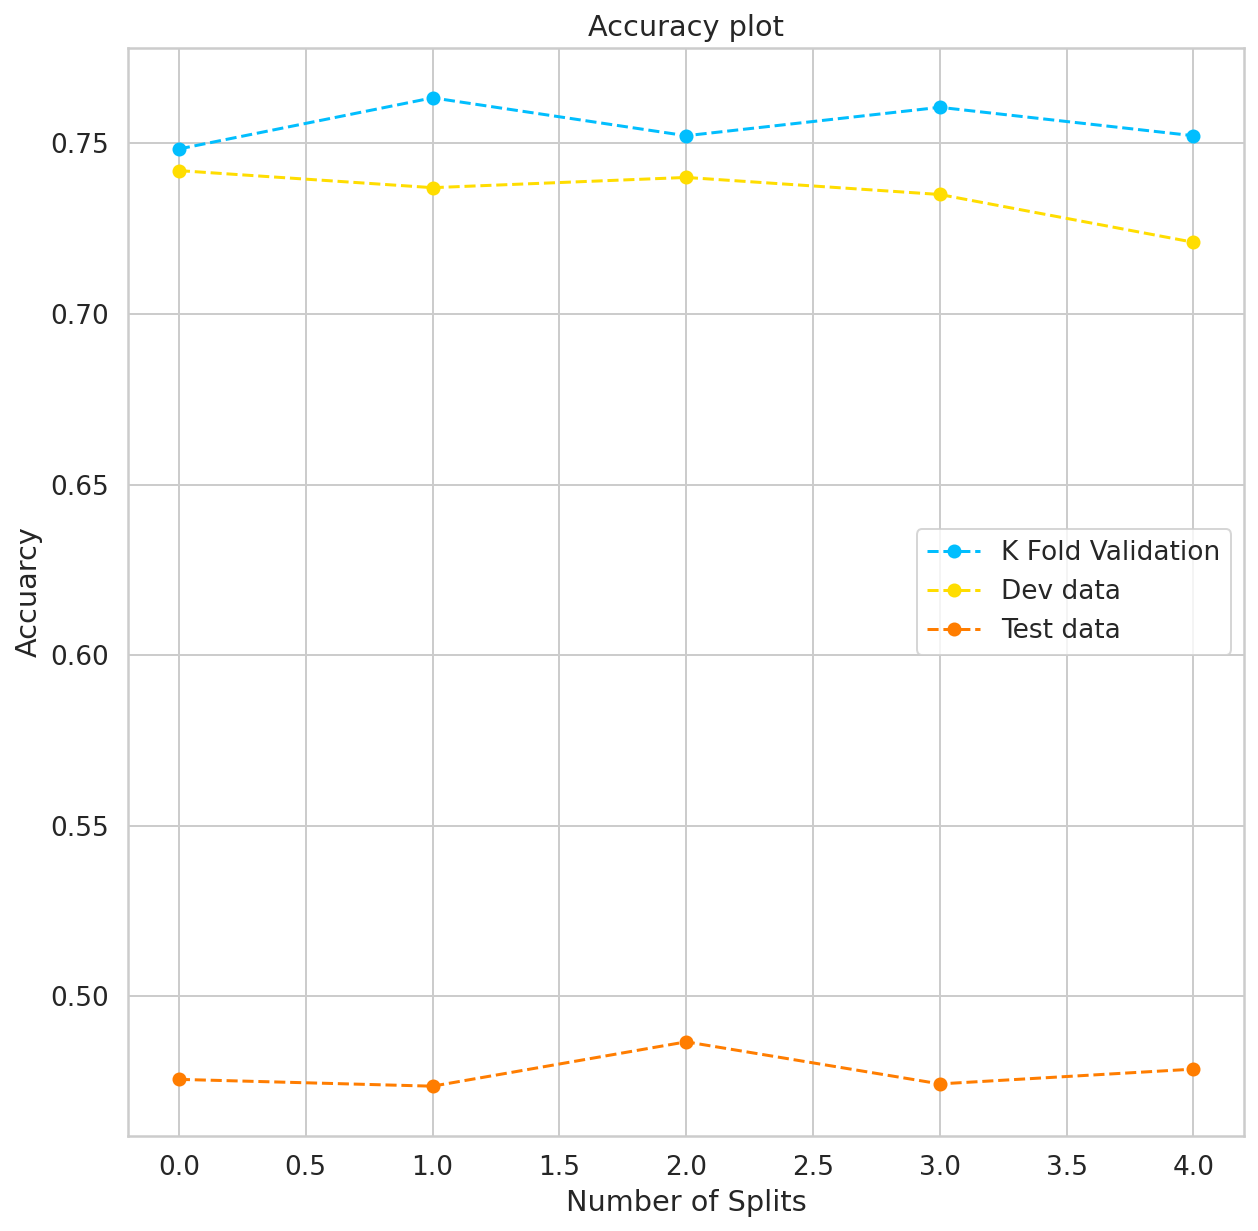

K Fold Validation Accuracy mean value :  0.7553333333333333 

Dev Data Accuracy mean value :  0.7350000000000001 

Test Data Accuracy mean value :  0.47779999999999995 



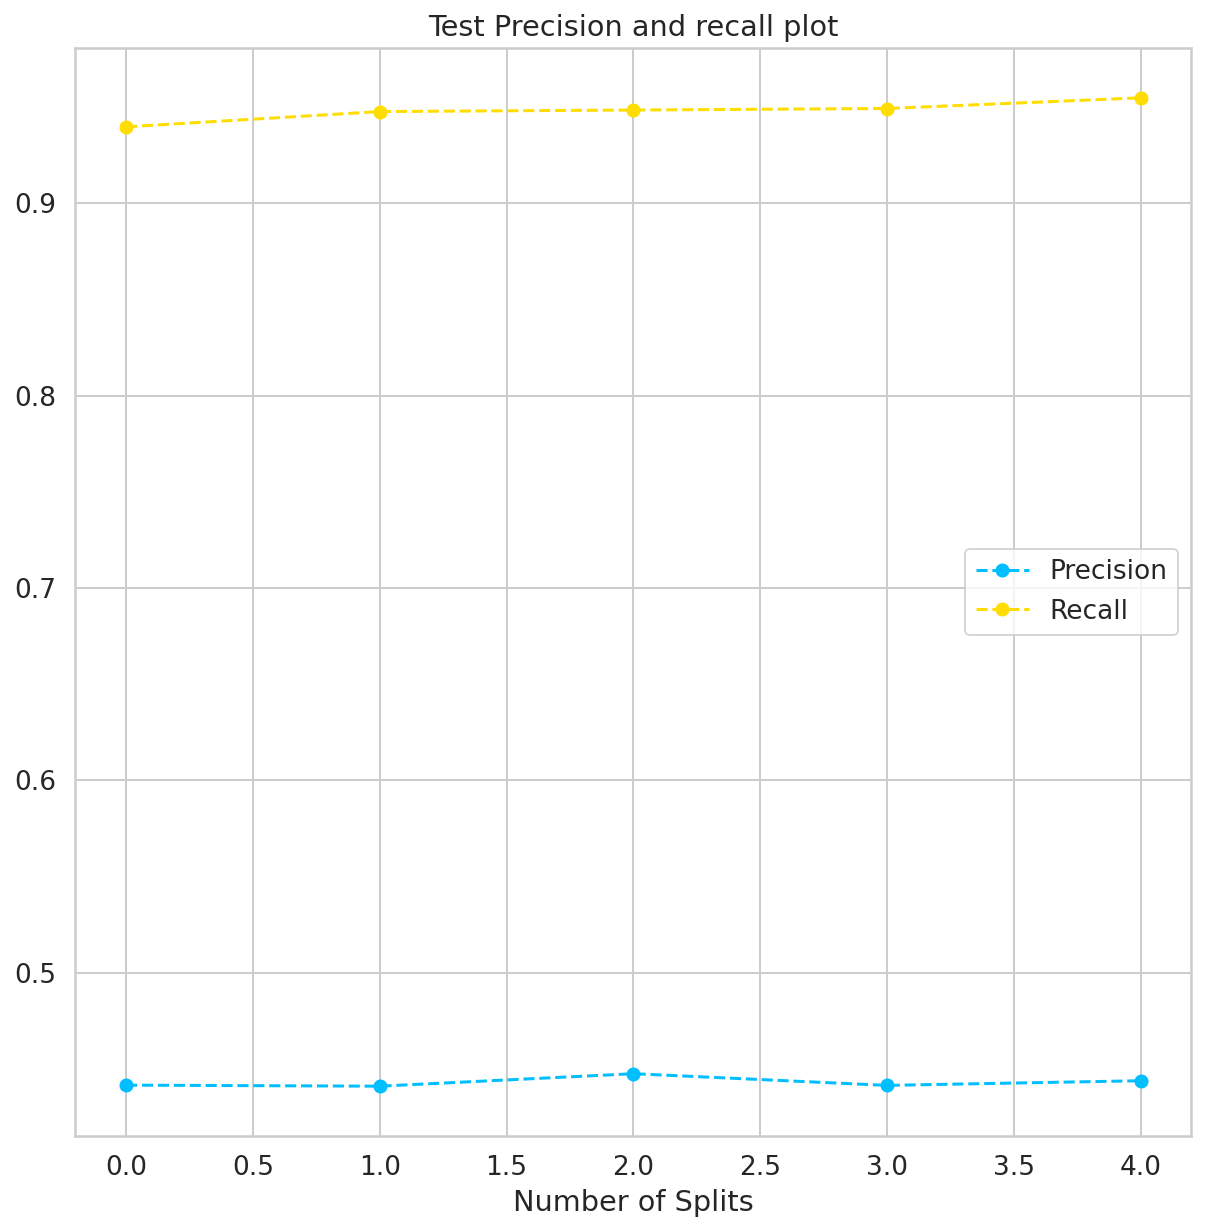

Test Data Precision Score mean value :  0.44313465022949317 

Test Data Recall Score mean value :  0.947936507936508 



In [ ]:
print("========Naive Bayes==========")
Naive = naive_bayes.MultinomialNB()
train(Naive)

## SVM with Universal Encoder sentence embeddings

In [ ]:
!pip install tensorflow-text

     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 458.3 MB 13 kB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 
     |████████████████████████████████| 1.3 MB 47.2 MB/s 
     |████████████████████████████████| 5.6 MB 33.4 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=24f10b7b0d0094e076c4d000586c4df17923fbd92642381a039f181f130b551c
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=a1f20b8e637d1e24ccdc099d5b33786876c6eddd48fe3e9da4ab71e33085a10c
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Success

In [ ]:
import tensorflow_hub as hub
import tensorflow_text

Loading Universal Sentence embedding

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

df_train['text'] = embed(df_train['text'])
df_test['text'] = embed(df_test['text'])

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual/3, Total size: 266.88MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.


In [ ]:
clf = svm.SVC(kernel='rbf', random_state=1, gamma='scale', C=0.1)

# train the model
clf.fit(list(df_train['text']), (df_train['label']))

# use the model to predict the testing instances
y_pred = clf.predict(list(df_test['text']))

# generate the classification report
print(classification_report(df_test['label'], y_pred))

print("Test Accuracy score : ", accuracy_score(df_test['label'], y_pred))
print("Test F1 score : ", f1_score(df_test['label'], y_pred))
print("Test Precision score : ", precision_score(df_test['label'], y_pred))
print("Test Recall score : ", recall_score(df_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.76      0.31      0.44      1740
           1       0.47      0.86      0.61      1260

    accuracy                           0.54      3000
   macro avg       0.61      0.59      0.53      3000
weighted avg       0.64      0.54      0.51      3000

Test Accuracy score :  0.541
Test F1 score :  0.6120033812341504
Test Precision score :  0.4744429882044561
Test Recall score :  0.861904761904762


In [ ]:
df_train, df_dev, df_test = load_dataset()
df_train.head()
df_train, df_dev, df_test = preprocess_data(df_train, df_dev, df_test)
df_train.head()

# Recurrent Neural Network(RNN)

In [ ]:
# reading glove embedding and creating weight matrix 
def read_glove_embedding(vocabulary_size, df, glove_path, embedding_size, tokenizer):

  embeddings_index = dict()

  f = open(glove_path)
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))

  embedding_matrix = np.zeros((vocabulary_size, embedding_size))
  for word, index in tokenizer.word_index.items():
      if index > vocabulary_size - 1:
          break
      else:
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[index] = embedding_vector

  return embedding_matrix

In [ ]:
# defining metrices to evaluate the model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# intializing tokenizer and fitting on train, test and dev data and padding to each sequences

vocabulary_size = 20000

maxlen = 200

tokenizer = Tokenizer(num_words=vocabulary_size)

#creating vocabulary on train data
tokenizer.fit_on_texts(df_train['text'])

#generating sequence of tokens on train, text, gold data
train_sequences = tokenizer.texts_to_sequences(df_train['text'])
dev_sequences = tokenizer.texts_to_sequences(df_dev['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

#padding the sequences
train_pad = pad_sequences(train_sequences, maxlen=maxlen)
dev_pad = pad_sequences(dev_sequences, maxlen=maxlen)
test_pad = pad_sequences(test_sequences, maxlen=maxlen)

Loading GloVe embedding

In [ ]:
glove_path = '/content/gdrive/MyDrive/glove.6B.300d.txt'
embedding_size = 300
embedding_matrix = read_glove_embedding(vocabulary_size, df_train, glove_path,  embedding_size, tokenizer)

## LSTM

###WITH GLOVE

In [ ]:
# constructing model
embedding_input_shape = 300
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, embedding_input_shape, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_glove.add(LSTM(64))
model_glove.add(Dropout(0.1))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',f1_m, precision_m, recall_m])

model_glove.fit(train_pad, np.array(df_train['label']), validation_data=(dev_pad, np.asarray(df_dev['label'])), epochs = 20, batch_size=128)

y_pred = model_glove.predict(test_pad)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(df_test['label'], y_pred))
print("Test Data accuracy: ", accuracy_score(df_test['label'], y_pred))
print("Test Data F1 Score: ", f1_score(df_test['label'], y_pred))

Loaded 400000 word vectors.
Epoch 1/20
71/71 [==============================] - 6s 49ms/step - loss: 0.5821 - binary_accuracy: 0.6860 - f1_m: 0.5928 - precision_m: 0.6416 - recall_m: 0.5787 - val_loss: 0.5538 - val_binary_accuracy: 0.6920 - val_f1_m: 0.5853 - val_precision_m: 0.7103 - val_recall_m: 0.5136
Epoch 2/20
71/71 [==============================] - 3s 38ms/step - loss: 0.5050 - binary_accuracy: 0.7491 - f1_m: 0.6958 - precision_m: 0.7090 - recall_m: 0.6936 - val_loss: 0.5355 - val_binary_accuracy: 0.7100 - val_f1_m: 0.6593 - val_precision_m: 0.6736 - val_recall_m: 0.6522
Epoch 3/20
71/71 [==============================] - 3s 38ms/step - loss: 0.4793 - binary_accuracy: 0.7692 - f1_m: 0.7186 - precision_m: 0.7378 - recall_m: 0.7185 - val_loss: 0.5339 - val_binary_accuracy: 0.7140 - val_f1_m: 0.6373 - val_precision_m: 0.7011 - val_recall_m: 0.5893
Epoch 4/20
71/71 [==============================] - 3s 37ms/step - loss: 0.4502 - binary_accuracy: 0.7856 - f1_m: 0.7410 - precision_m:

## GRU

### With GLoVE

In [ ]:
# constructing model
embedding_input_shape = 300
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, embedding_input_shape, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_glove.add(GRU(64))
model_glove.add(Dropout(0.1))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',f1_m, precision_m, recall_m])


model_glove.fit(train_pad, np.array(df_train['label']), validation_data=(dev_pad, np.asarray(df_dev['label'])), epochs = 20, batch_size=128)

y_pred = model_glove.predict(test_pad)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(df_test['label'], y_pred))
print("Test Data accuracy: ", accuracy_score(df_test['label'], y_pred))
print("Test Data F1 Score: ", f1_score(df_test['label'], y_pred))

Loaded 400000 word vectors.
Epoch 1/20
71/71 [==============================] - 6s 54ms/step - loss: 0.6173 - binary_accuracy: 0.6499 - f1_m: 0.5235 - precision_m: 0.6094 - recall_m: 0.4903 - val_loss: 0.5737 - val_binary_accuracy: 0.6950 - val_f1_m: 0.6525 - val_precision_m: 0.6616 - val_recall_m: 0.6702
Epoch 2/20
71/71 [==============================] - 3s 41ms/step - loss: 0.5230 - binary_accuracy: 0.7447 - f1_m: 0.6813 - precision_m: 0.7165 - recall_m: 0.6630 - val_loss: 0.5426 - val_binary_accuracy: 0.7090 - val_f1_m: 0.6239 - val_precision_m: 0.7302 - val_recall_m: 0.5662
Epoch 3/20
71/71 [==============================] - 3s 39ms/step - loss: 0.4804 - binary_accuracy: 0.7741 - f1_m: 0.7215 - precision_m: 0.7433 - recall_m: 0.7120 - val_loss: 0.5407 - val_binary_accuracy: 0.7110 - val_f1_m: 0.6765 - val_precision_m: 0.6560 - val_recall_m: 0.7029
Epoch 4/20
71/71 [==============================] - 3s 38ms/step - loss: 0.4542 - binary_accuracy: 0.7857 - f1_m: 0.7408 - precision_m:

# Transformer

## BERT

Downloading the simpletransformers library

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 247 kB 10.8 MB/s 
     |████████████████████████████████| 8.3 MB 46.4 MB/s 
     |████████████████████████████████| 290 kB 49.8 MB/s 
     |████████████████████████████████| 1.7 MB 34.9 MB/s 
     |████████████████████████████████| 1.2 MB 38.1 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 180 kB 49.3 MB/s 
     |████████████████████████████████| 139 kB 45.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 243 kB 50.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.9 MB/s 
     |████████████████████████████████| 132 kB 48.2 MB/s 
     |████████████████████████████████| 160 kB 46.1 MB/s 
     |████████████████████████████████| 271 kB 52.7 MB/s 
     |████████████████████████████████| 192 kB 53.2 MB/s 
     |████████████████████████████████| 111 kB 52.9 MB/s 
     |██████████████

Necessary Imports

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import random as rn
import os

from simpletransformers.classification import ClassificationModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Training the model

In [ ]:
model = ClassificationModel('bert', 'bert-base-uncased', args={'num_train_epochs': 3, 'overwrite_output_dir': True})

# Train the model
model.train_model(df_train)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_dev)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/9000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 3:   0%|          | 0/1125 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1125 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating the model performance

In [ ]:
preds, mo = model.predict(df_test['text'].tolist())
print(classification_report(df_test['label'], preds))
print("Test F1-Score : ", f1_score(df_test['label'], preds))
print("Test Accuracy : ", accuracy_score(df_test['label'], preds))

              precision    recall  f1-score   support

           0       0.94      0.18      0.30      1740
           1       0.47      0.98      0.63      1260

    accuracy                           0.52      3000
   macro avg       0.70      0.58      0.47      3000
weighted avg       0.74      0.52      0.44      3000

Test F1-Score :  0.6316861946001018
Test Accuracy :  0.518
